# The fast spectral method

By choosing the test function $\phi(v) = e^{-i\frac{\pi}{L} k\cdot v}$ in the weak form, we can obtain the Fourier expansion of $Q$:

$$\hat{Q}_k= \sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1} G(l,m) \hat{f}_l \hat{f}_m\,,$$

where the weight $G(l,m)$ is given by

$$
G(l,m)=\int_{\mathbb{R}^d}e^{-i\frac{\pi}{L}m \cdot g}\bigg[\int_{S^{d-1}}B_{\sigma}(\lvert g\rvert,\sigma\cdot \hat{g})\left(e^{-i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot (|g|\sigma-g)}-1\right)\,\mathrm{d}{\sigma}\bigg]\,\mathrm{d}{g} \,,
$$

where $g$ needs to be truncated properly as was done for the elastic case. 

The idea of the fast algorithm is to separate the weight $G$ as $G(l,m)\approx\sum_{t=1}^T\alpha_t(l+m)\beta_t(m)$ using quadrature rules.

In [1]:
%matplotlib inline
import numpy as np
from math import pi
from scipy import special
import matplotlib.pyplot as plt
import pyfftw

import sys
sys.path.append('../src')
from fast_spec_col_3d import FastSpectralCollison3D
from direct_col_3d import DirectCol3D
from utility import get_config, RK3

## 3D case

In 3D, and VHS case $B_{\sigma}(|g|,\sigma\cdot \hat{g})=C_{\gamma}|g|^{\gamma}$:

$$
\int_{S^2}B_{\sigma}(|g|,\sigma\cdot \hat{g})\left(e^{-i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot (|g|\sigma-g)}-1\right)\,\mathrm{d}\sigma=4\pi C_{\gamma}|g|^{\gamma}\bigg[ e^{i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot g}\text{Sinc}\left(\frac{\pi}{L}\frac{1+e}{4}\vert l+m \vert|g|\right)-1\bigg],
$$

then let $\rho=|g|$, $\sigma=\hat{g}$,

$$
G(l,m)=\sum_{\rho,\sigma}w_{\rho}w_{\sigma}4\pi C_{\gamma}\rho^{\gamma+2}e^{-i\frac{\pi}{L}\rho m \cdot \sigma}\left[ e^{i\frac{\pi}{L}\frac{1+e}{4}\rho (l+m)\cdot \sigma}\text{Sinc}\left(\frac{\pi}{L}\frac{1+e}{4}|l+m|\rho\right)-1\right],
$$

therefore,

$$ 
\hat{Q}_k=\sum_{\rho,\sigma}w_{\rho}w_{\sigma}4\pi C_{\gamma}\rho^{\gamma+2}\left[ e^{i\frac{\pi}{L}\frac{1+e}{4}\rho k\cdot \sigma}\text{Sinc}\left(\frac{\pi}{L}\frac{1+e}{4}\rho |k|\right)-1\right]\sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1}\hat{f}_l \left[e^{-i\frac{\pi}{L}\rho m \cdot \sigma}\hat{f}_m\right],
$$

or the loss term can be computed separately as

$$ 
\hat{Q}_k^-=\sum_{\rho,\sigma}w_{\rho}w_{\sigma}4\pi C_{\gamma}\rho^{\gamma+2}\sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1}\hat{f}_l \left[e^{-i\frac{\pi}{L}\rho m \cdot \sigma}\hat{f}_m\right]=\sum_{\rho}w_{\rho}16\pi^2 C_{\gamma}\rho^{\gamma+2}\sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1}\hat{f}_l \left[\text{Sinc}\left(\frac{\pi}{L}\rho |m|\right)\hat{f}_m\right].
$$

## Direct method

In 3D, and VHS case $B_{\sigma}(|g|,\sigma\cdot \hat{g})=C_{\gamma}|g|^{\gamma}$:

$$
\int_{S^2}B_{\sigma}(|g|,\sigma\cdot \hat{g})\left(e^{-i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot (|g|\sigma-g)}-1\right)\,\mathrm{d}\sigma=4\pi C_{\gamma}|g|^{\gamma}\bigg[ e^{i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot g}\text{Sinc}\left(\frac{\pi}{L}\frac{1+e}{4}\vert l+m \vert|g|\right)-1\bigg],
$$

then let $\rho=|g|$, $\sigma=\hat{g}$,

$$
G(l,m)=\sum_{\rho}w_{\rho}16\pi^2 C_{\gamma}\rho^{\gamma+2}\left[\text{Sinc}\left(\frac{\pi}{L}\left|\frac{1+e}{4}(l+m)-m\right|\rho\right)\text{Sinc}\left(\frac{\pi}{L}\frac{1+e}{4}|l+m|\rho\right)-\text{Sinc}\left(\frac{\pi}{L}\rho|m|\right)\right],
$$

# Fast Spectral Method

In [135]:
def isotropic_f(v):
    t = 6.5
    K = 1 - np.exp(-t/6)
    v_norm = v[:,None,None]**2 + v[:,None]**2 + v**2
    return 1/(2*(2*pi*K)**(3/2))*np.exp(-(v_norm)/(2*K))*((5*K-3)/K+(1-K)/(K**2)*(v_norm))

def extQ(v):
    t = 6.5
    K = 1 - np.exp(-t/6)
    dK = np.exp(-t/6)/6
    v_norm = v[:,None,None]**2 + v[:,None]**2 + v**2
    df = (-3/(2*K)+(v_norm)/(2*K**2))*f + 1/(2*(2*pi*K)**(3/2))*np.exp(-v_norm/(2*K))*(
    3/(K**2)+(K-2)/(K**3)*v_norm)
    return df*dK

def anisotropic_f(v):
    return 0.8*pi**(-1.5)*(np.exp(-16**(1/3)*((v-2)[:,None,None]**2 + (v-2)[:,None]**2 + (v-2)**2)) 
                           + np.exp(-(v+0.5)[:,None,None]**2-(v+0.5)[:,None]**2 - (v+0.5)**2))

def maxwellian(v, rho, u, T):
    v_u = ((v - u[0])**2)[:,None,None] + ((v - u[1])**2)[:,None] + (v - u[2])**2
    return rho/(2*pi*T)**(3/2)*np.exp(-v_u/(2*T))

In [3]:
config_3D = get_config('../src/configs/config_3D.json')

Q_direct = DirectCol3D(config_3D)
# Q_direct.save_Glm('../data/Glm_02_32')
Q_direct.get_Glm_from_file('../data/Glm_e02_32_zip.npz')

In [4]:
%time Q_direct_col = Q_direct.col(anisotropic_f(Q_direct.v))/(4*pi)

CPU times: user 25.2 s, sys: 936 ms, total: 26.1 s
Wall time: 26.2 s


In [21]:
config_3D = get_config('../src/configs/config_3D.json')
Q = FastSpectralCollison3D(config_3D)

In [22]:
%time Q_sep = Q.col_sep(anisotropic_f(Q.v))/(4*pi)
np.max(np.abs(Q_sep - Q_direct_col))

CPU times: user 10.8 s, sys: 2.96 s, total: 13.7 s
Wall time: 6.36 s


3.747408101774895e-05

$e=0.2$, $N=32$ with anisotropic initial

| Spherical Design | Error | time |
| ------ | ------ | ------- |
| 6 | 1.4674566108660258e-02 | 275ms |
| 12 | 9.532325835757156e-03 | 510ms |
| 32 | 5.92707599850977e-03 | 1.07s |
| 48 | 1.952601851310574e-03 | 1.61s |
| 70 | 1.43696494086e-03 | 2.74s |
| 94 | 4.354500695785647e-04 | 3.65s |
| 120 | 3.534377201557734e-04 | 3.98s |
| 156 | 9.811152052724729e-05 | 6.35s |
| 192 | 3.747408101774895e-05 | 6.36s |

In [91]:
config_3D = get_config('../src/configs/config_3D.json')
Q_gauss = FastSpectralCollison3D(config_3D)

In [92]:
%time Q_gauss_sep = Q_gauss.col_sep(anisotropic_f(Q_gauss.v))/(4*pi)
np.max(np.abs(Q_gauss_sep - Q_direct_col))

CPU times: user 11.8 s, sys: 3.06 s, total: 14.8 s
Wall time: 7.03 s


0.0012310868626689182

$e=0.2$, $N=32$ with anisotropic initial using gauss quadrature

| # of ($\theta$, $\phi$) | Error | time |
| ------ | ------ | ------- |
| (2,3) | 9.301850859331023e-03 | 253s |
| (3,4) | 1.4164542178285952e-02 | 494ms |
| (4,8) | 2.148725985732372e-02 | 1.08s |
| (6,8) | 3.952940827407407e-03 | 1.6s |
| (7,10) | 3.3540095954422665e-03 | 2.98s |
| (10,10) | 3.405850043869026e-03 | 4.15s |
| (10,12) | 3.016912442998702e-03 | 4.56s |
| (11,15) | 1.227818352872178e-03 | 6.86s |
| (12,16) | 1.2310868626689182e-03 | 7.03s |

In [3]:
def plot_time(N, cost1, cost2, name):
    fig, ax = plt.subplots()
    ax.loglog(N, cost1, 'o-', label='Computation time$')
    ax.loglog(N, cost2, label='reference: 3-order')
    ax.set_xlabel('$N$')
    ax.set_ylabel('Time')
    ax.set_title('Convergence of RK3 in $\Delta t$')
    ax.legend(fontsize='large')
    ax.grid(which='both',linestyle=':')
#     plt.savefig(name)
    plt.show()

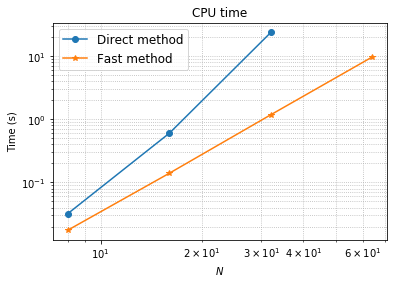

In [30]:
fig, ax = plt.subplots()
ax.loglog(N, cost_direct, 'o-', label='Direct method')
ax.loglog(N_fast, cost_fast, '*-', label='Fast method')
ax.set_xlabel('$N$')
ax.set_ylabel('Time (s)')
ax.set_title('CPU time')
ax.legend(fontsize='large')
ax.grid(which='both',linestyle=':')
plt.savefig('CPU time.pdf')
plt.show()

$e=0.2$, Spherical design number $= 32$

| N | Direct method | Fast method |
| ------ | ------ | ------ |
| 8 | 32.2ms | 17.6ms |
| 16 | 602ms | 140ms |
| 32 | 23.7s | 1.18s|
| 64 | -- | 9.7s |

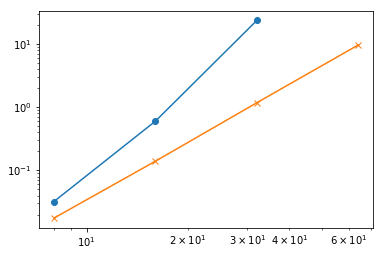

In [22]:
N = [8, 16, 32]
cost_direct = [32.2e-3, 6.02e-1, 23.7]
fig, ax = plt.subplots()
ax.loglog(N, cost_direct, 'o-', label='Computation time$')
ax.loglog(N_fast, cost_fast, 'x-', label='Computation time$')

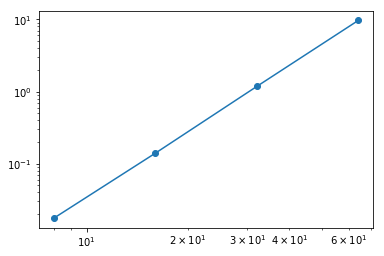

In [21]:
N_fast = [8, 16, 32, 64]
cost_fast = [17.6e-3, 1.40e-1, 1.18, 9.7]
fig, ax = plt.subplots()
ax.loglog(N_fast, cost_fast, 'o-', label='Computation time$')

In [ ]:
# 6, 223ms
np.max(np.abs(Q_direct - Q_1))

In [ ]:
# 12, 458ms
np.max(np.abs(Q_direct - Q_1))

In [ ]:
# 32, 1.22s
np.max(np.abs(Q_1 - Q_direct))

In [ ]:
# 48, 1.79s
np.max(np.abs(Q_1 - Q_direct))

In [ ]:
# 70, 2.5s
np.max(np.abs(Q_1 - Q_direct))

In [ ]:
# 94, 3.38s
np.max(np.abs(Q_1 - Q_direct))

In [ ]:
# 120, 4.43s
np.max(np.abs(Q_1 - Q_direct))

$e=0.2$, $N=32$ with isotropic initial

| Spherical Design | Error |
| ------ | ------ |
| 6 | 0.00041820767783433107 | 
| 12 | 3.1726851245650724e-05 |
| 32 | 6.5752814213618921e-07 |
| 48 | 5.6132233266191489e-07 |
| 70 | 2.6714628356683257e-07 |
| 94 | 1.0508293902503248e-07 |
| 120 | 2.8872928147741922e-08 | 

We also have $\rho_0 = 1$, $u_0 = 0$, $E = T$. Temperature $T$ safisfies:

$$
T=\left(T_0-\frac{8\varepsilon}{1-e^2}\right)\exp{\left(-\frac{1-e^2}{4}t\right)}+\frac{8\varepsilon}{1-e^2}.
$$

In [94]:
def T(t, e, eps, T_0):
    return (T_0 - 8*eps/(1-e**2))*np.exp(-(1-e**2)*t/4) + 8*eps/(1-e**2)

In [142]:
M = lambda v: maxwellian(v, 1, (0.5, -0.5, 0), 2)

In [ ]:
%%time

dt = 0.01
eps = 0

config_3D = get_config('../src/configs/config_3D.json')
Q = FastSpectralCollison3D(config_3D)

f_hat = []

f_0 = M(Q.v)
E_0 = 0.5*np.sum(f_0*Q.v_norm)*Q.dv**3
f = Q.fft3(f_0).copy()

for t in range(300):
    f = RK3(f, Q.col_heat_sep, eps, dt)
    f_hat.append(f)
    
f = np.real(Q.ifft3(f))
E = 0.5*np.sum(f*Q.v_norm)*Q.dv**3

In [28]:
np.sum(f_0)*Q.dv**3, np.sum(f_0*Q.v)*Q.dv**3, np.sum(f_0*Q.v_norm)*Q.dv**3/3

(0.9999999965144858, -2.708634755624087e-18, 2.166666564305162)

In [133]:
T(1.0, 0.2, eps, E_0*2/3) - E*2/3

-0.000396517639616345

In [7]:
%%time
T_vhs = []
for t in range(300):
    f = np.real(Q.ifft3(f_hat[t]))
    T_vhs.append(0.5*np.sum(f*Q.v_norm)*Q.dv**3*2/3)

CPU times: user 257 ms, sys: 38.5 ms, total: 296 ms
Wall time: 118 ms


In [29]:
%%time
T_vhs_02 = []
for t in range(300):
    f = np.real(Q.ifft3(f_hat[t]))
    T_vhs_02.append(0.5*np.sum(f*Q.v_norm)*Q.dv**3*2/3)

CPU times: user 261 ms, sys: 21.4 ms, total: 282 ms
Wall time: 112 ms


In [44]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf

In [126]:
learning_rate = 0.1
training_epochs = 2000
display_step = 50

# a = tf.Variable(1.0, tf.float32)
c = tf.Variable(0.42, tf.float32)
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

model = T_vhs_02[0]/(1.0 + c*x)**2
loss = tf.reduce_sum(tf.square(model - y))/299

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):
        sess.run(optimizer, feed_dict={x: (np.arange(300)/100)[1:], y: T_vhs_02[1:]})
        #Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch: " + str(epoch)+ " loss = " 
                  + str(sess.run(loss, feed_dict={x: (np.arange(300)/100)[1:], y: T_vhs_02[1:]}))
                  + " c = " + str(sess.run(c)))       

Epoch: 0 loss = 0.00088943564 c = 0.42105532
Epoch: 50 loss = 0.0008818453 c = 0.42321277
Epoch: 100 loss = 0.0008818453 c = 0.42321277
Epoch: 150 loss = 0.0008818453 c = 0.42321277
Epoch: 200 loss = 0.0008818453 c = 0.42321277
Epoch: 250 loss = 0.0008818453 c = 0.42321277
Epoch: 300 loss = 0.0008818453 c = 0.42321277
Epoch: 350 loss = 0.0008818453 c = 0.42321277
Epoch: 400 loss = 0.0008818453 c = 0.42321277
Epoch: 450 loss = 0.0008818453 c = 0.42321277
Epoch: 500 loss = 0.0008818453 c = 0.42321277
Epoch: 550 loss = 0.0008818453 c = 0.42321277
Epoch: 600 loss = 0.0008818453 c = 0.42321277
Epoch: 650 loss = 0.0008818453 c = 0.42321277
Epoch: 700 loss = 0.0008818453 c = 0.42321277
Epoch: 750 loss = 0.0008818453 c = 0.42321277
Epoch: 800 loss = 0.0008818453 c = 0.42321277
Epoch: 850 loss = 0.0008818453 c = 0.42321277
Epoch: 900 loss = 0.0008818453 c = 0.42321277
Epoch: 950 loss = 0.0008818453 c = 0.42321277
Epoch: 1000 loss = 0.0008818453 c = 0.42321277
Epoch: 1050 loss = 0.0008818453 c =

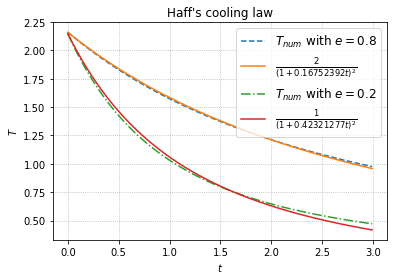

In [129]:
t = (np.arange(300)/100)

fig, ax = plt.subplots()
ax.plot(t, np.asarray(T_vhs), '--', label=r'$T_{num}$ with $e=0.8$')
ax.plot(t, T_vhs[0]/(1 + 0.16752392*t)**2, label=r'$\frac{2}{(1+0.16752392t)^2}$')
ax.plot(t, np.asarray(T_vhs_02), '-.', label=r'$T_{num}$ with $e=0.2$')
ax.plot(t, T_vhs_02[0]/(1.0 + 0.42321277*t)**2, label=r'$\frac{1}{(1+0.42321277t)^2}$')
ax.set_xlabel('$t$')
ax.set_ylabel('$T$')
ax.set_title('Haff\'s cooling law')
ax.legend(fontsize='large')
ax.grid(which='both',linestyle=':')
plt.savefig('Haff_cooling_new.pdf')
plt.show()

# plt.plot(t, np.asarray(T_vhs), '--', t, 2.25/(1+0.36*t)**2)

In [31]:
def T(t, e, eps, T_0):
    return (T_0 - 8*eps/(1-e**2))*np.exp(-(1-e**2)*t/4) + 8*eps/(1-e**2)

In [99]:
# e=0.2, 003
T(1, 0.2, eps, E_0*2/3) - E*2/3

0.2661413377541729

In [103]:
# e=0.2, 005
T(1, 0.2, eps, E_0*2/3) - E*2/3

0.16773023124809094

In [107]:
# e=0.2, 007
T(1, 0.2, eps, E_0*2/3) - E*2/3

0.10297536867238799

In [112]:
# e=0.2, 009
T(1, 0.2, eps, E_0*2/3) - E*2/3

0.02584202650005074

In [118]:
# e=0.2, 011
T(1, 0.2, eps, E_0*2/3) - E*2/3

-0.02422376071694199

In [122]:
# e=0.2, 013
T(1, 0.2, eps, E_0*2/3) - E*2/3

-0.003058799838901116

In [126]:
# e=0.2, 015
T(1, 0.2, eps, E_0*2/3) - E*2/3

0.004413127388460447

In [130]:
# e=0.2, 017
T(1, 0.2, eps, E_0*2/3) - E*2/3

-0.001220110856786194

In [134]:
# e=0.2, 019
T(1, 0.2, eps, E_0*2/3) - E*2/3

-0.000396517639616345

$T = 1$, $\Delta t = 0.01$ with anisotropic initial

| Spherical Design | 0.2 |
| ------ | ------ |
| 6 | 2.661413377541729e-01 | 
| 12 | 1.6773023124809094e-01 |
| 32 | 1.0297536867238799e-01 |
| 48 | 2.584202650005074e-02 |
| 70 | 2.422376071694199e-02 |
| 94 | 3.058799838901116e-03 |
| 120 | 4.413127388460447e-03 |
| 156 | 1.220110856786194e-03 |
| 192 | 3.96517639616345e-04 |

$T = 1$, $\Delta t = 0.01$ with isotropic initial

| Spherical Design | 0.2 |
| ------ | ------ |
| 6 | 0.0013957739849754791 | 
| 12 | 9.9706271716293315e-05 |
| 32 | 2.2499901350947482e-06 |
| 48 | 2.4272557155313734e-06 |
| 70 | 2.4703481364962698e-06 |
| 94 | 2.4703481364962698e-06 |
| 120 | 2.453380453903975e-06 | 